## SET UP

In [1]:
import cv2 
import os
import pathlib
import numpy as np
import json
import matplotlib.pyplot as plt
import glob
import re
import zipfile
import shutil
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab import drive
from google.colab.patches import cv2_imshow

In [2]:
# check if this code run on colab GPU else change runtime to GPU manually
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
  print(f'Found GPU at: {device_name}')

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## LOAD DATA

In [4]:
# extract zip data
if os.path.isdir('vn_hcr') is True:
  shutil.rmtree('vn_hcr')
data_zip_path = '/content/gdrive/MyDrive/Data_ML_Study/vn_handwritten.zip'
with zipfile.ZipFile(data_zip_path, 'r') as zip_ref:
  zip_ref.extractall('vn_hcr/raw')

In [5]:
# set path
current_path = pathlib.Path('./vn_hcr').absolute()
data_dir = os.path.join(str(current_path), 'data')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
raw_dir = os.path.join(str(current_path), 'raw')
labels_dir = os.path.join(str(current_path), 'labels')

In [6]:
# create data folder
os.makedirs(data_dir)
os.makedirs(train_dir)
os.makedirs(test_dir)
os.makedirs(labels_dir)

In [7]:
# move labels.json file from raw dir to labels dir
shutil.move('/content/vn_hcr/raw/labels.json','/content/vn_hcr/labels/labels.json')

'/content/vn_hcr/labels/labels.json'

In [8]:
# read label form json file
label_list = json.load(open('/content/vn_hcr/labels/labels.json'))
label_list

{'1.jpg': 'Số 3 Nguyễn Ngọc Vũ, Hà Nội',
 '2.jpg': 'Số 30 Nguyên Hồng, Láng Hạ, Đống Đa, Hà Nội',
 '3.jpg': '58 Thái Thịnh, Đống Đa, Hà Nội',
 '4.jpeg': 'Số 370/8 khu phố 5B, phường Tân Biên, Biên Hòa, Đồng Nai',
 '5.jpg': 'Vĩnh Trung Plaza, B, 255-257 đường Hùng Vương, phường Vĩnh Trung',
 '6.jpg': 'Tòa nhà 34T, Hoàng Đạo Thúy, Hà Nội',
 '7.jpg': '40 Cát Linh, Đống Đa, Hà Nội',
 '8.jpg': 'phòng 101, tầng 1, lô 04-TT5B, khu đô thị Tây Nam Linh Đàm',
 '9.JPG': 'Nhà 87 ngõ 416 Đê La Thành',
 '10.JPG': 'Up coworking Space, 89 Láng Hạ, Hà Nội',
 '11.jpg': '192 Ngô Đức Kế, quận 1, Hồ Chí Minh',
 '12.jpg': 'số 5 Công Trường Mê Linh, phường Bến Nghé, quận 1',
 '13.jpg': '90A đường Mai Xuân Thưởng, tỉnh Gia Lai',
 '14.jpg': '96/7/12B Phạm Văn Đồng, thành phố Pleiku',
 '15.jpg': '168 Ngô Gia Tự, thành phố Hà Tĩnh',
 '0000_samples.png': 'Số 253 đường Trần Phú, Thị trấn Nam Sách, Huyện Nam Sách, Hải Dương',
 '0001_samples.png': 'Số 289 Đinh Bộ Lĩnh, Phường 26, Quận Bình Thạnh, TP Hồ Chí Minh',
 '

In [9]:
# get all character from the label list
char_list = set()
for label in label_list.values():
  char_list.update(label)
char_list = sorted(char_list)

In [10]:
# encoding each output word into digits of indexes
def encode_to_labels(txt):
  digit_list = []
  for index, char in enumerate(txt):
    try:
      digit_list.append(char_list.index(char))
    except:
      print("No found in char list: ", char)
  return digit_list

In [11]:
# merge img path and its label into a dict
data_dict = {}
data_path = pathlib.Path(os.path.join(raw_dir))
for item in data_path.glob('**/*'):
  img_name = str(os.path.basename(item))
  label = label_list[img_name]
  data_dict[str(item)] = label
data_dict

{'/content/vn_hcr/raw/0277_samples.png': '320/2 Cô Giang, Phường 02, Quận Phú Nhuận, TP Hồ Chí Minh',
 '/content/vn_hcr/raw/0264_samples.png': 'Số 4/44 Ngô Quyền, Phường Xương Huân, Thành phố Nha Trang, Khánh Hòa',
 '/content/vn_hcr/raw/0801_samples.png': 'Số 696/13, Khu phố Tân Phước, Phường Tân Bình, TX Dĩ An, Bình Dương',
 '/content/vn_hcr/raw/1616_samples.png': 'Thôn Làng Mới, Huyện Văn Yên, Yên Bái',
 '/content/vn_hcr/raw/1259_samples.png': 'Khu 7, Phường Hải Yên, Thành phố Móng cái, Quảng Ninh',
 '/content/vn_hcr/raw/1310_samples.png': '233 Đường Số 6, Phường 7, Quận Gò Vấp, TP Hồ Chí Minh',
 '/content/vn_hcr/raw/0406_samples.png': '1275/4 Phan Văn Trị, Phường 10, Quận Gò Vấp, TP Hồ Chí Minh',
 '/content/vn_hcr/raw/1354_samples.png': 'Thôn Hòa Sơn, Xã Cao Thượng, Huyện Tân Yên, Bắc Giang',
 '/content/vn_hcr/raw/0477_samples.png': 'Tổ 32, phố Tiền Phong, Phường Tiên Cát, Thành Phố Việt Trì, Phú Thọ',
 '/content/vn_hcr/raw/0964_samples.png': 'Số 91 Nguyễn Khuyến, Phường Tân Lợi, TP

In [12]:
print("Total img found: ", len(data_dict.keys()))
print("Total labels found: ", len(data_dict.values()))
print("Total characters found: ", len(char_list))
print("Character:" + ''.join(char_list))

Total img found:  1838
Total labels found:  1838
Total characters found:  140
Character: #'()+,-./0123456789:ABCDEFGHIJKLMNOPQRSTUVWXYabcdeghiklmnopqrstuvwxyzÂÊÔàáâãèéêìíòóôõùúýăĐđĩũƠơưạảấầẩậắằẵặẻẽếềểễệỉịọỏốồổỗộớờởỡợụủỨứừửữựỳỵỷỹ


In [13]:
img_path = list(data_dict.keys())
img_label = list(data_dict.values())

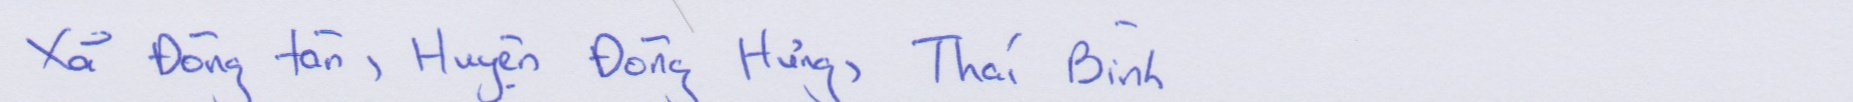

Xã Đông tân, Huyện Đông Hưng, Thái Bình
0042_samples.png
[44, 76, 0, 90, 84, 57, 51, 0, 63, 75, 57, 6, 0, 28, 64, 68, 113, 57, 0, 90, 84, 57, 51, 0, 28, 96, 57, 51, 6, 0, 40, 52, 74, 53, 0, 22, 80, 57, 52]


(102, 1853, 3)

In [14]:
# check an img
index = 1213
img = cv2.imread(img_path[index])
cv2_imshow(img)
print(img_label[index])
print(os.path.basename(img_path[index]))
print(encode_to_labels(img_label[index]))
img.shape

In [15]:
del(img)

# PREPROCESS DATA

In [16]:
# find max label len
list_label_len = []
for label in data_dict.values():
  list_label_len.append(len(label))
max_label_len = max(list_label_len)
max_label_len

69

In [17]:
# split the data
train_img, valid_img = train_test_split(img_path, test_size = 0.2, random_state = 1)

In [18]:
# time steps need to > than max_label len to avoid transition sequence error
time_steps = 200

In [19]:
# training data
training_img = []
training_txt = []
train_input_length = []
train_label_length = []
orig_txt = []
max_width=0
for image in train_img:
    # read img, convert gray, resize to max size, blur, threshold, normalize
    img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2GRAY)
    h, w = img.shape
    img = cv2.resize(img, (int(128/h*w), 128), interpolation = cv2.INTER_AREA)
    h, w = img.shape
    img = np.pad(img, ((0,0),(0, 2350-w)), 'median')
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 9, 5)
    img = np.expand_dims(img, axis = 2)
    img = img/255.
    # add
    label = data_dict[image]
    orig_txt.append(label)   
    train_label_length.append(len(label))
    train_input_length.append(time_steps)
    training_img.append(img)
    training_txt.append(encode_to_labels(label)) 

In [20]:
# validation data
valid_img = []
valid_txt = []
valid_input_length = []
valid_label_length = []
valid_orig_txt = []
for image in valid_img:
    # read img, convert gray, resize to max size, blur, threshold, normalize
    img = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2GRAY)
    h, w = img.shape
    img = cv2.resize(img, (int(128/h*w), 128), interpolation = cv2.INTER_AREA)
    h, w = img.shape
    img = np.pad(img, ((0,0), (0, 2350-w)), 'median')
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 9, 5)
    img = np.expand_dims(img, axis = 2)
    img = img/255.
    # add
    label = data_dict[image]
    valid_orig_txt.append(label)   
    valid_label_length.append(len(label))
    valid_input_length.append(time_steps)
    valid_txt.append(encode_to_labels(label))

In [21]:
# pad each output label to maximum text length
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_padded_txt = pad_sequences(training_txt, maxlen = time_steps, padding='post', value = 0)
valid_padded_txt = pad_sequences(valid_txt, maxlen = time_steps, padding='post', value = 0)

In [22]:
train_padded_txt[178]

array([ 19,  14,  23,   0,  23,  46,  58,   0,  40,  52, 103,  57,  51,
         6,   0,  36,  52,  96, 124,  57,  51,   0,  10,  14,   6,   0,
        37,  64, 102,  57,   0,  13,   6,   0,  40,  36,   0,  28, 119,
         0,  23,  52,  81,   0,  33,  53,  57,  52,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

# MODEL BUIDLING

In [23]:
# import model, different layers and activation function 
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, Lambda, Bidirectional, Add, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow.keras.backend as K

In [24]:
inputs = Input(shape=(128, 2350, 1))
# Layer 1
model = Conv2D(64, (3,3), padding='same')(inputs)
model = MaxPooling2D(3,3)(model)
model = Activation('relu')(model)
# Layer 2
model = Conv2D(128, (3,3), padding='same')(model)
model = MaxPooling2D(3,3)(model)
model = Activation('relu')(model)
# Layer 3
model = Conv2D(256, (3,3), padding='same')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
# Layer 4
model = Conv2D(256, (3,3), padding='same')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
# Layer 5
model = Conv2D(512, (3,3), padding='same')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
# Layer 6
model = Conv2D(512, (3,3), padding='same')(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
# Layer 7
model = Conv2D(1024, (3,3), padding='same')(model)
model = BatchNormalization()(model)
model = MaxPooling2D(pool_size=(3, 1))(model)
model = Activation('relu')(model)
model = MaxPooling2D(pool_size=(3, 1))(model)
# remove the first dimension 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(model)
# RNN with bidirectional layer
blstm_1 = Bidirectional(LSTM(512, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(512, return_sequences=True, dropout = 0.2))(blstm_1)
# softmax character proprobility with timesteps 
outputs = Dense(len(char_list)+1, activation = 'softmax')(blstm_2)
# model 
act_model = Model(inputs, outputs)

In [25]:
act_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 2350, 1)]    0         
                                                                 
 conv2d (Conv2D)             (None, 128, 2350, 64)     640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 783, 64)      0         
 )                                                               
                                                                 
 activation (Activation)     (None, 42, 783, 64)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 783, 128)      73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 261, 128)     0         
 2D)                                                         

In [26]:
# define input shape
labels = Input(name='the_labels', shape=[time_steps], dtype='float32')
# define the length of input and label for ctc
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

In [27]:
 # define a ctc lambda function to take arguments and return ctc_bach_cost
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
# out loss function (just take the inputs and put it in our ctc_batch_cost)
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

# model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam', run_eagerly=True)
 
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

callbacks_list = [checkpoint]

In [29]:
# ready training data
training_img = np.array(training_img)
train_input_length = np.array(train_input_length)  
train_label_length = np.array(train_label_length)  

# ready validating data
valid_img = np.array(valid_img)
valid_input_length = np.array(valid_input_length) 
valid_label_length = np.array(valid_label_length) 

In [30]:
del(data_dict, label_list, img_path, img_label)

In [ ]:
batch_size = 16 # 32
epochs = 100 # 50

history = model.fit(x=[training_img, train_padded_txt, train_input_length, train_label_length], 
          y=np.zeros(len(training_img)),
          batch_size=batch_size, 
          epochs = epochs,
          validation_data = ([valid_img, valid_padded_txt, valid_input_length, valid_label_length], [np.zeros(len(valid_img))]),
          verbose = 1, 
          callbacks = callbacks_list)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
92/92 [==============================] - ETA: 0s - loss: 2.1429
Epoch 1: loss improved from inf to 2.14287, saving model to best_model.hdf5
92/92 [==============================] - 82s 884ms/step - loss: 2.1429
Epoch 2/100
92/92 [==============================] - ETA: 0s - loss: 2.9848
Epoch 2: loss did not improve from 2.14287
92/92 [==============================] - 83s 901ms/step - loss: 2.9848
Epoch 3/100
92/92 [==============================] - ETA: 0s - loss: 4.7588
Epoch 3: loss did not improve from 2.14287
92/92 [==============================] - 83s 899ms/step - loss: 4.7588
Epoch 4/100
92/92 [==============================] - ETA: 0s - loss: 5.7234
Epoch 4: loss did not improve from 2.14287
92/92 [==============================] - 82s 896ms/step - loss: 5.7234
Epoch 5/100
92/92 [==============================] - ETA: 0s - loss: 2.6421
Epoch 5: loss did not improve from 2.14287
92/92 [==============================] - 83s 897ms/step - loss: 2.6421
Epoch 6/100
92/92

# EVALUATION

In [32]:
import string
import unicodedata
import editdistance

In [33]:
def ocr_metrics(predicts, ground_truth, norm_accentuation=False, norm_punctuation=False):
    """Calculate Character Error Rate (CER), Word Error Rate (WER) and Sequence Error Rate (SER)"""

    if len(predicts) == 0 or len(ground_truth) == 0:
        return (1, 1, 1)

    cer, wer, ser = [], [], []

    for (pd, gt) in zip(predicts, ground_truth):

        if norm_accentuation:
            pd = unicodedata.normalize("NFKD", pd).encode("ASCII", "ignore").decode("ASCII")
            gt = unicodedata.normalize("NFKD", gt).encode("ASCII", "ignore").decode("ASCII")

        if norm_punctuation:
            pd = pd.translate(str.maketrans("", "", string.punctuation))
            gt = gt.translate(str.maketrans("", "", string.punctuation))

        pd_cer, gt_cer = list(pd.lower()), list(gt.lower())
        dist = editdistance.eval(pd_cer, gt_cer)
        cer.append(dist / (max(len(pd_cer), len(gt_cer))))

        pd_wer, gt_wer = pd.lower().split(), gt.lower().split()
        dist = editdistance.eval(pd_wer, gt_wer)
        wer.append(dist / (max(len(pd_wer), len(gt_wer))))

        pd_ser, gt_ser = [pd], [gt]
        dist = editdistance.eval(pd_ser, gt_ser)
        ser.append(dist / (max(len(pd_ser), len(gt_ser))))

    cer_f = sum(cer) / len(cer)
    wer_f = sum(wer) / len(wer)
    ser_f = sum(ser) / len(ser)

    return (cer_f, wer_f, ser_f)